In [1]:
#EP Phys 512
#Question 4

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
from wmap_camb_example import get_spectrum
import corner

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

In [3]:
#write a Markov-chain Mmonte carlo
#fit basic 6 parameters, including tau

#REJECT any steps that try to sammple a negative tau.

#SAVE THE CHAINS

#use covariance matrix from part 2

In [4]:
#some useful functions

#providing chi2 for the data
def chi2(data, pars):
    ypred = get_spectrum(pars)
    ypred = ypred[2:1199+2] #chop down to correct size
    return np.sum( (data[:,1] - ypred)**2/data[:,2]**2 ) #wmap[:,1] =data , 2=std on data point


def acceptance_rate(chain):
    count = sum( (chain[1:, 0] - chain[0:-1, 0] ) != 0)
    acc_rate = count/chain.shape[0]
    print('total count is ', count)
    print('length of chain is ', chain.shape[0])
    print('acceptance rate is ', acc_rate)
    return acc_rate

def markov_cholesky(pars, wmap, r, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars + np.dot(r, np.random.randn(r.shape[0])) #add dist drawn from cholesky
        if pars_trial[3] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            accept_prob = np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec

def markov_stepsize(pars, wmap, par_step, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars+np.random.randn(npar)*par_step #randomly add to each parameters
        if pars_trial[3] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            accept_prob = np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec

In [5]:
# STEP 0: SET UP BASIC PARAMETERS

n = 50000 #number of steps
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') #this is the data

#use best fit parameters from previous section 3
pars = np.asarray([6.93351658e+01, 2.24911838e-02, 1.13886400e-01, 5.00000000e-02,
 2.04230773e-09, 9.69783026e-01])

#was previously using errors from 3 but switched to other method
# par_step = np.asarray([ 1.54518611e-04, -1.74432104e-07, -1.25736616e-06,  0.00000000e+00,
#  -1.47018482e-14, -2.65730611e-06])
# par_sigs = np.asarray([[3.72050854e+00, 8.63940293e-04, 7.15760479e-03, 1.53078691e-01,
#  5.91976432e-10, 2.67853773e-02]])

#testing cholesky etc
mat = np.loadtxt('newton_lhs.txt')
r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars
print(mat)
print(r)
print('test random addition would be ', np.dot(r, np.random.randn(r.shape[0])))
      
mat_old = np.loadtxt('newton_lhs_old_multiple_iters.txt')
r_old = np.linalg.cholesky(np.linalg.inv(mat_old)) #create cholesky matrix for generating pars
print(mat)
print(r)
print('test random addition would be ', np.dot(r_old, np.random.randn(r_old.shape[0])))


[[ 2.28705440e+00 -3.63357567e+03  1.21766508e+03  2.10081210e+02
  -5.17480706e+10  2.88360048e+01]
 [-3.63357567e+03  1.78671795e+07 -1.95496174e+06 -2.23827467e+05
   5.63009769e+13 -4.55138632e+05]
 [ 1.21766508e+03 -1.95496174e+06  1.78276276e+06  6.52030015e+05
  -1.62700934e+14  1.70232652e+05]
 [ 2.10081210e+02 -2.23827467e+05  6.52030015e+05  2.88208465e+05
  -7.20084829e+13  7.07826253e+04]
 [-5.17480706e+10  5.63009769e+13 -1.62700934e+14 -7.20084829e+13
   1.80033918e+22 -1.79686572e+13]
 [ 2.88360048e+01 -4.55138632e+05  1.70232652e+05  7.07826253e+04
  -1.79686572e+13  4.05807522e+04]]
[[ 3.90007977e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.64861162e-04  4.84253739e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.95796377e-03  1.83691939e-03  1.85494684e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.20829987e-01  3.91354107e-02 -2.14320925e-02  8.37116288e-02
   0.00000000e+00  0.000

In [6]:
if False: #if we want to fit using the cholesky matrix from part 3
    
    #generate cholesky matrix
    mat = np.loadtxt('newton_lhs.txt')
    r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars

    n=20
    chain, chi2vec = markov_cholesky(pars, wmap, r, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain))

In [7]:
#if we want to fit using the information from a previous markov chain
if False:
    n=20000
    chain_old = np.loadtxt('chain36k_nozeros.txt')
    par_sigs_old = np.std(chain_old, axis=0)
    print('old step sizes', par_sigs_old)
    
    #from examining the previous chain we find that the tau parameter step size is so large that it
    #often tries to send tau negative, which is rejected instantly, lowering our acceptance rate
    #this large step size is therefore unphysical. so in this instance I reduce the step size manually for tau.
    #NOTE: this did not work well. VERY much unconverged after 20000 points.
    
    par_sigs_old[3] = par_sigs_old[3]/10
    print('adjusting tau step, par_steps now ', par_sigs_old)
    
    chain, chi2vec = markov_stepsize(pars, wmap, par_sigs_old, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain))

In [8]:
#SAVE MARKOV CHAIN
#this will overwrite it
# np.savetxt("chain.txt", chain)
# np.savetxt("chi2vec.txt", chi2vec)

In [9]:
#load data
chain = np.loadtxt("chain36k_nozeros.txt")
chi2vec = np.loadtxt("chi2vec36k_nozeros.txt")

#in the case of the chain crashing partway remove extraneous zeros from end of chain
# zeros = int(np.sum(chi2vec==0))
# print('number of zeros are ', zeros)
# print('n-zeros ', n-zeros)
# chain = chain[0:-zeros, :]
# chi2vec = chi2vec[0:-zeros]

# # np.savetxt("chain36k_nozeros.txt", chain)
# # np.savetxt("chi2vec36k_nozeros.txt", chi2vec)

chain sigmas are  [2.70250010e+00 5.98881396e-04 5.59598042e-03 4.95085364e-02
 2.07539729e-10 1.71585411e-02]
chain means are  [7.04557043e+01 2.26871212e-02 1.11872307e-01 8.61259375e-02
 2.19340160e-09 9.77865014e-01]
total count is  2393
length of chain is  33068
acceptance rate is  0.07236603362767631
the acceptance rate of the chain is  0.07236603362767631


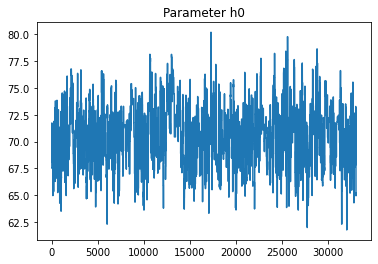

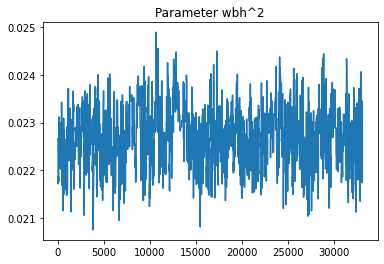

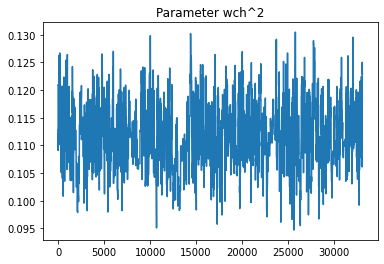

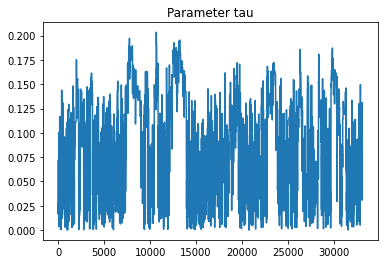

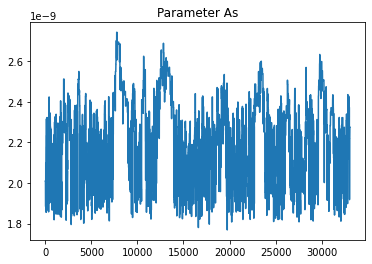

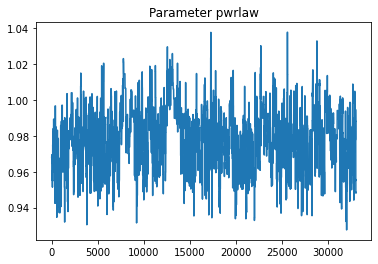

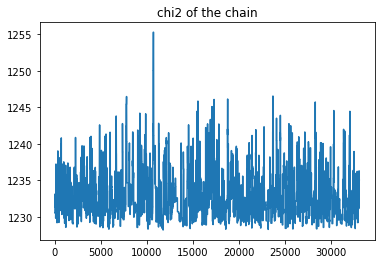

In [10]:
print('chain sigmas are ', np.std(chain, axis=0))
print('chain means are ', np.mean(chain, axis=0))
print('the acceptance rate of the chain is ', acceptance_rate(chain))

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()

corner plot of chain 


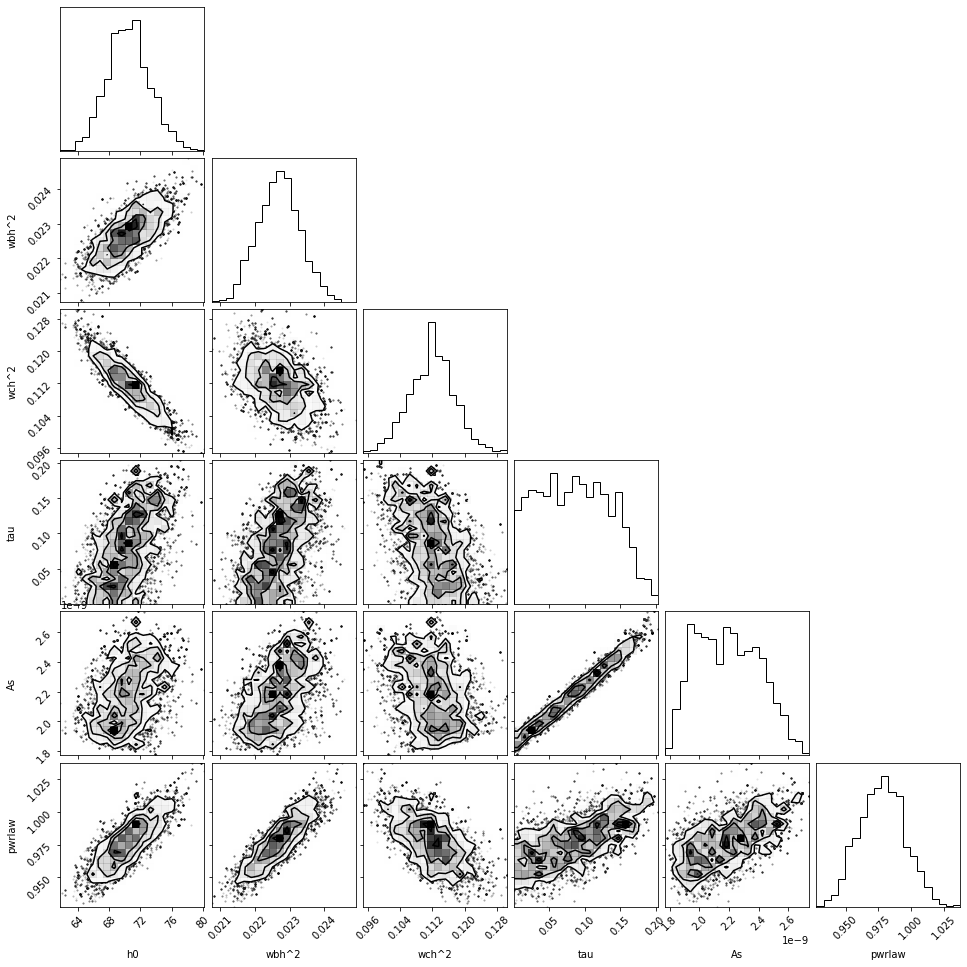

In [11]:
print('corner plot of chain ')
figure = corner.corner(chain, labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw'])